# Hamline Marketing Analytics Clinic (MAC) 
[<img align="left" alt="hu" width="200px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi0.wp.com%2Fcheesebrowmusic.com%2Fwp-content%2Fuploads%2F2018%2F06%2Fsos-partner-logo-hamline-university_2x.png%3Fw%3D3840&f=1&nofb=1" />][hu]

[hu]: https://www.hamline.edu/

<br/>
<br/>
<br/>
<br/>

## Application Case Study

### Max Bolger, 2020

[<img align="left" alt="linkedin" width="45px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.freebiesupply.com%2Flogos%2Flarge%2F2x%2Flinkedin-icon-logo-png-transparent.png&f=1&nofb=1" />][linkedin]

[<img align="left" alt="github" width="50px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.afterdawn.fi%2Fv3%2Fnews%2Foriginal%2Fgithub-logo.png&f=1&nofb=1" />][github]

[<img align="left" alt="twitter" width="45px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn4.iconfinder.com%2Fdata%2Ficons%2Fsocial-media-icons-the-circle-set%2F48%2Ftwitter_circle-512.png&f=1&nofb=1" />][twitter]

<br/>
<br/>
<br/>

*right-click the icons to visit my respective pages!*
<br/>

<a href="https://github.com/maxbolger/HUMAC_Application/blob/main/ResumeMaxBolger.pdf">
  <button type="button">View My Resume Here!</button>
</a>

---

[github]: https://github.com/maxbolger
[linkedin]:https://www.linkedin.com/in/max-bolger/
[twitter]: https://twitter.com/mnpykings

## Importing Packages

In [2]:
#importing all necessary packages for this analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

#aesthetic settings
plt.style.use('fivethirtyeight')

## Loading Data

In [3]:
resp = pd.read_csv("survey_responses.csv")

resp.head()

,CustomerID,Response
0,470,Both Or None
1,1074,Both Or None
2,862,AmznPrime
3,935,AmznPrime
4,974,Both Or None


In [4]:
ord_ = pd.read_csv("order_behavior.csv")

ord_.head()

,CustomerID,OrderCount,OrderAvgSize,AvgDeliverCost,AvgOrderValue
0,1,18,13,4.57,9.33
1,2,31,13,4.57,9.36
2,3,17,6,4.02,4.71
3,4,26,12,4.51,8.77
4,5,4,8,4.22,5.79


In [91]:
print(resp.shape)
print(ord_.shape)
print(f"{ord_.shape[0] - resp.shape[0]} customers in the " \
      "pilot program did not fill out the survey...")

(2178, 2)
(2229, 5)
51 customers in the pilot program did not fill out the survey...


Interesting... We will get these 51 customers and set them aside for later.

In [6]:
#getting all non respondents... saving this for later
non_resp = ord_[~ord_['CustomerID'].isin(resp['CustomerID'])].dropna().reset_index(drop=True)

#there are only two na so instead of taking the time 
#to fill with the median, we can just drop them

## Data Cleaning

In [7]:
#merging (on customer ID) the survey data with order behavior
merged = pd.merge(
    resp, ord_, on='CustomerID'
    ).sort_values(
        by='CustomerID',ascending=True
        ).set_index('CustomerID')

merged.head()

,Response,OrderCount,OrderAvgSize,AvgDeliverCost,AvgOrderValue
CustomerID,,,,,
1,Walmart+,18,13,4.57,9.33
2,Walmart+,31,13,4.57,9.36
3,Both Or None,17,6,4.02,4.71
4,Walmart+,26,12,4.51,8.77
5,Both Or None,4,8,4.22,5.79


In [8]:
#should be 2178, since we merged
merged.shape

(2178, 5)

In [9]:
#descriptive statistics
merged.describe().round(2)

,OrderCount,OrderAvgSize,AvgDeliverCost,AvgOrderValue
count,2178.00,2178.00,2080.00,2178.00
mean,18.72,9.76,4.30,7.47
std,10.98,4.21,0.31,2.88
min,1.00,2.00,3.24,2.40
25%,10.25,7.00,4.13,5.20
50%,17.00,9.00,4.31,7.08
75%,25.00,12.00,4.51,9.34
max,55.00,24.00,4.97,16.25


In [30]:
#descriptive statistics by Response type
merged.groupby('Response').describe().round(2)

OrderCount                      ... AvgOrderValue                    
                  count   mean    std   min  ...           25%   50%    75%    max
Response                                     ...                                  
AmznPrime         392.0  12.41   3.75   3.0  ...          8.71  9.30  11.00  16.25
Both Or None     1099.0  17.20  12.80   1.0  ...          4.12  5.21   5.86  13.46
Walmart+          687.0  24.75   7.04  11.0  ...          8.18  9.34  10.51  15.75

[3 rows x 32 columns]

In [31]:
#variance of each column
merged.var()

OrderCount        120.596053
OrderAvgSize       17.713777
AvgDeliverCost      0.097911
AvgOrderValue       8.278756
dtype: float64

In [32]:
#checking na value counts.
merged.isna().sum()

Response           0
OrderCount         0
OrderAvgSize       0
AvgDeliverCost    98
AvgOrderValue      0
dtype: int64

There is some missing data in `AvgDeliverCost`. We can fix this by filling `na` values with the `AvgDeliverCost` median value. This works great since there's hardly any variance in `AvgDeliverCost` as seen above.

The methodology here is that 98 is a decent chunk (~3.6%) of observations. Since the variance in `AvgDeliverCost` is very low, we can keep those 98 observations by filling with the median value without much error. In other words, the median is a solid estimation as seen below.

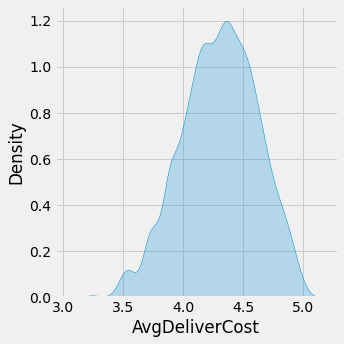

In [42]:
sns.displot(data=merged, x="AvgDeliverCost", kind="kde", fill=True)

In [43]:
#filling na values with median values
merged['AvgDeliverCost'] = (
    np.where(
    merged['AvgDeliverCost'].isna(), 
    merged['AvgDeliverCost'].median(), 
    merged['AvgDeliverCost'])
    )

In [44]:
#should be no na values now
merged.isna().sum()

Response          0
OrderCount        0
OrderAvgSize      0
AvgDeliverCost    0
AvgOrderValue     0
dtype: int64

Perfect, now there is no missing data. The next step is to proceed with performing some exploratory data analysis.

## EDA

A pairplot is a great way to get a descriptive first look at any data.

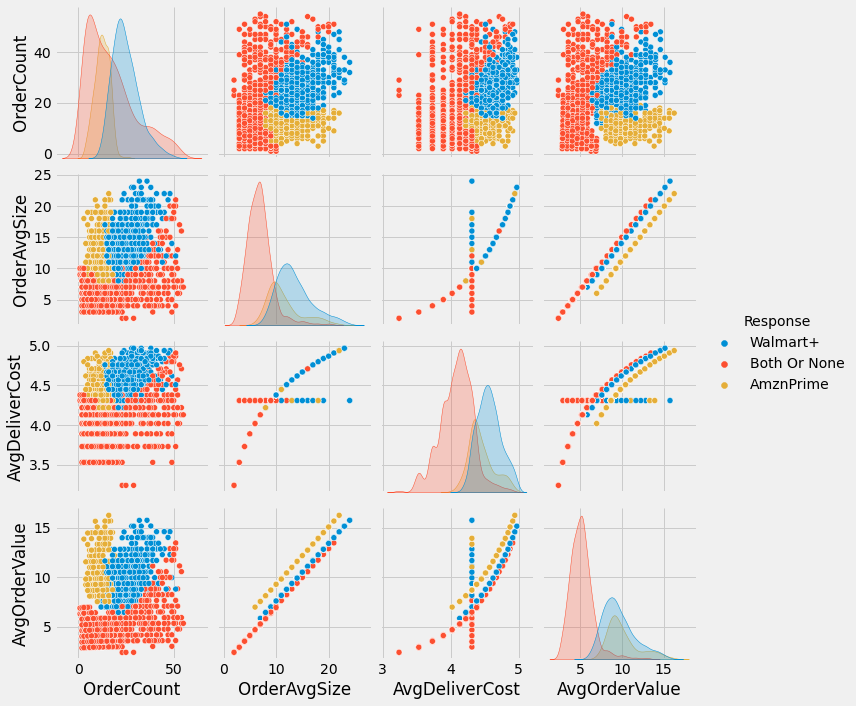

In [45]:
sns.pairplot(merged, hue="Response")

Some initial thoughts:

- `AmznPrime` is the least preferred option of respondents by far. They also don't appear to be very profitable customers for Walmart.

- `Both Or None` is the majority option of respondents and look as though they can be profitable customers for Walmart. 

- The `OrderCount` distribution and the top left is intriguing... Let's take a better look at that.

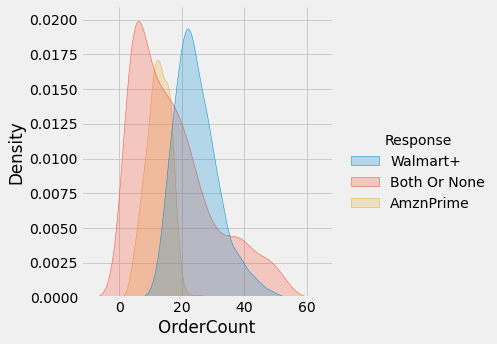

In [25]:
sns.displot(merged, x="OrderCount", hue="Response", kind="kde",fill=True)

`AmznPrime` respondents make significantly less purchases than both `Walmart+` and `Both Or None` respondents on average. This means that `AmznPrime` respondents may be less valuable. We can create a simple metric that measures a customer's value during the pilot program by multiplying their `OrderCount` by their `AvgOrderValue`. Let's do that and visualize the top 50 most valuable customers in the pilot program.

Text(0.5, 1.0, 'Highest Value Customers and Their Response Type')

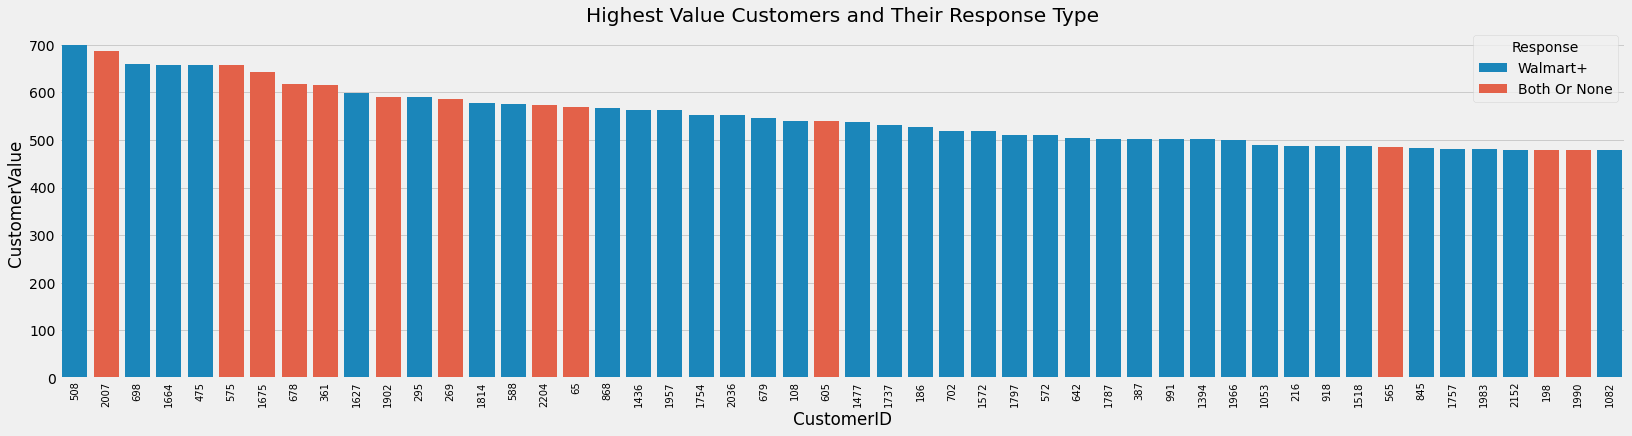

In [90]:
#calculating and visualizing customer value
merged['CustomerValue'] = merged['OrderCount'] * merged['AvgOrderValue']

value = merged.sort_values(by='CustomerValue',ascending=False).head(50)

fig, ax = plt.subplots(figsize=(25,6))

sns.barplot(x=value.index, y="CustomerValue", data=value, 
            order=value.index, hue='Response', dodge=False)

plt.xticks(fontsize=10, rotation=90)
plt.title('Highest Value Customers and Their Response Type')

Wow! Out of the top 50 most valuable customers, **none** are `AmznPrime` respondents. 37 are `Walmart+` respondents, while 13 are `Both Or None`. The low ceiling of order counts from `AmznPrime` respondents is very important to take note of! Perhaps they didn't like the pilot program and ordered less as a result. Walmart should be cognizant of this and allocate less resources towards gaining loyalty from `AmznPrime` respondents, as they are low value customers and already favor Amazon Prime. These indifferent customers, however, is where Walmart can make huge profits. Not only are they some of the most valuable customers, but they aren't opinionated either! If I were Walmart, I'd be doing anything I could to either continue the pilot program with these indifferent respondents and/or earn their loyalty through other means (add them to a mailing list for coupons, etc.). Walmart seems to already have the audience they want, and now they just need to make this next step to get these extra, profitable customers.

Also - as the pairplot suggests, there are *a lot* more indifferent respondents than Amazon Prime respondents. This, in addition to the aforementioned findings, prove the indifferent respondents to be a higher EV investment in terms of pursuing their loyalty. 

#### ***High value, greater amount, not opinionated > low value, lesser amount, opinionated***


Calculating aggregate data by `Response` to see the averages of each category.

In [49]:
#aggregate data by Response
agg = merged.groupby('Response').agg(
    {'OrderCount':'mean',
     'OrderAvgSize':'mean',
     'AvgDeliverCost':'mean',
     'AvgOrderValue':'mean',
     'Response':'count'}
     ).rename(
         columns={'Response':'count'}
         ).round(2)

#this is just so the 3 response colors match on all plots
agg = agg.reindex(index=agg.index[::-1])

agg

,OrderCount,OrderAvgSize,AvgDeliverCost,AvgOrderValue,count
Response,,,,,
Walmart+,24.75,13.45,4.56,9.61,687
Both Or None,17.20,6.85,4.08,5.18,1099
AmznPrime,12.41,11.46,4.44,10.13,392


Those who prefer Walmart+ made the most purchases in the Walmart pilot program, on average. Priors confrimed here. Visualizing this data conveys it more effectively.

Text(0.5, 0.98, 'Aggregate Data by Response Type')

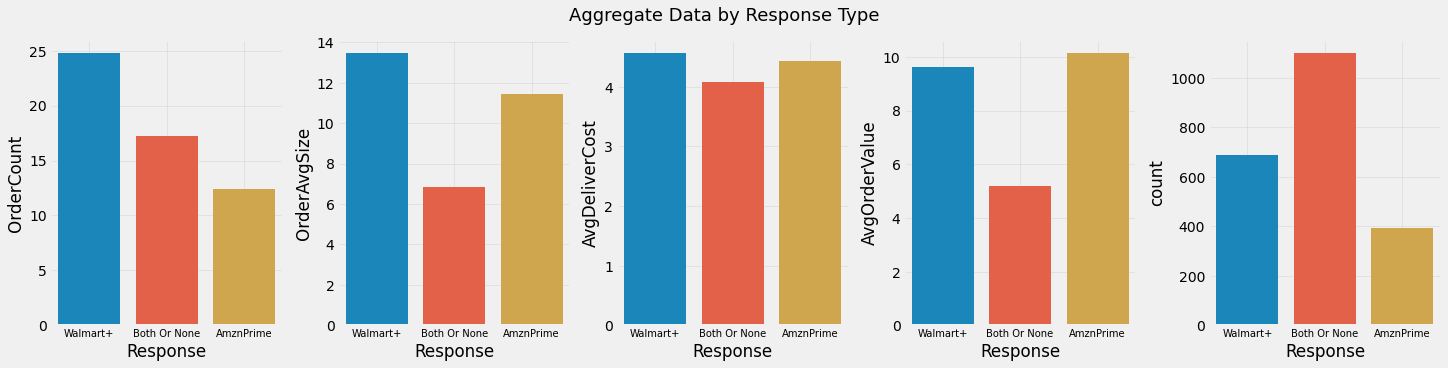

In [50]:
#visualizing aggregate data
fig, ax = plt.subplots(1,5,sharex=True,figsize=(20,5),constrained_layout=True)

ax = ax.flatten()
cols = ['OrderCount', 'OrderAvgSize', 'AvgDeliverCost', 
        'AvgOrderValue', 'count']

for a, c in zip(ax, cols):
    sns.barplot(x=agg.index, y=agg[c], ax=a, data=agg)
    a.grid(zorder=0,alpha=.4)
    a.set_axisbelow(True)
    a.tick_params(axis='x', which='major', labelsize=10)

plt.suptitle('Aggregate Data by Response Type',fontsize=18)

- `Walmart+` respondents logged a generously greater amount of orders as opposed to `Both Or None` or `AmznPrime` respondents, on average.
  - It is still important to keep the `OrderCount` distribution in mind here. While `Both Or None` respondents lie in the middle, on average, they offer a lot more potential as profitable customers due to their ceiling of many, many orders per customer (right tail end of distribution).

- Both `AmznPrime` and `Walmart+` respondents logged larger orders than that of `Both Or None` respondents, on average.

- Both `AmznPrime` and `Walmart+` respondents logged more expensive orders than that of `Both Or None` respondents (about double, on average).

- A majority of the respondents were `Both Or None`, followed by `Walmart+`, and then `AmznPrime` 
  - Again, this indecisiveness of the many `Both Or None` respondents is something Walmart should capitalize on!

# Modeling - Can we predict response type with customer behavior data?



## Preparation

We will use some basic classification algorithms for this data set. First, we will prepare the data by selecting features, splitting the data into training and testing sets, and then scaling it.

In [51]:
#defining features and response
X = merged[
           ['OrderCount',	'OrderAvgSize',	'AvgDeliverCost',	'AvgOrderValue']
           ].values
y = merged['Response'].values

In [52]:
#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=0
    )

It is very important to normalize AFTER splitting so our model doesn't "leak data". That is, normalization shouldn't be done using information that may eventually be part of the test set; we aren't supposed to know that data while training! 

In [53]:
#normalizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Firstly, a Naive Bayes Benchmark Classifier

We will create a Naive classifier to see what our benchmark is for our models.

In [54]:
#instanciating and running a naive model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy_score(y_test, y_pred)

0.8853211009174312

Our benchmark accuracy score is ~88.5%. Let's improve upon this naive classifier!

## Multinomial Logistic Regression

In [56]:
#instantiating and running a logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.981651376146789

Wow! This is a very accurate model with an accuracy score of ~98.2%!

In [57]:
#getting predicted classes for confusion matrix
y_pred = lr.predict(X_test)

#creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

Text(36.099999999999994, 0.5, 'Actual')

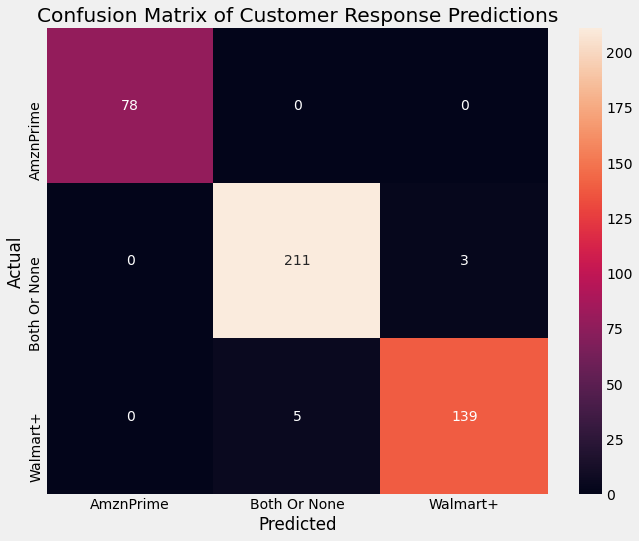

In [58]:
#visualizing confusion matrix
classes = list(lr.classes_)

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix of Customer Response Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Only 8 incorrectly labeled customers. That's great! (Something I am unsure of is how to detect false positives/negatives within a multinomial classification? Something I would further expand upon if I had more time...)

Now that we have tested the model, we can use the customers who did not fill out the survey to run more out of sample testing. This information is very important, as these may be potential customers Walmart would want to recruit!

In [71]:
#out of sample testing
#instantiate and fit the model
oos_lr = LogisticRegression(max_iter=10000)
oos_lr.fit(X, y)

#get predictions with oos data
oos_pred = oos_lr.predict(non_resp.to_numpy()[:,1:])

#get probabilities of each predicted class
oos_pred_prob = oos_lr.predict_proba(non_resp.to_numpy()[:,1:]).max(axis=1)

In [73]:
#put all of this into a dataframe
oos_classes = pd.DataFrame(data=oos_pred.flatten())

oos_classes_prob = pd.DataFrame(data=oos_pred_prob.flatten())

non_resp['Pred_Response'] = oos_classes

non_resp['Pred_Response_Prob'] = oos_pred_prob

In [75]:
non_resp.head()

,CustomerID,OrderCount,OrderAvgSize,AvgDeliverCost,AvgOrderValue,Pred_Response,Pred_Response_Prob
0,76,14,9,4.31,8.71,AmznPrime,0.988945
1,96,2,9,4.31,6.34,Both Or None,0.960483
2,105,8,10,4.38,9.26,AmznPrime,0.997874
3,117,30,9,4.31,6.47,Both Or None,0.984295
4,141,21,8,4.22,5.88,Both Or None,0.983027


In [76]:
non_resp.Pred_Response.value_counts()

Both Or None    26
AmznPrime       16
Walmart+         7
Name: Pred_Response, dtype: int64

Based on our model, there are potentially 26 more customers Walmart could recruit! Let's see how valuable they are.

Text(0.5, 1.0, 'Value of Nonrespondents and Their Predicted Response Type')

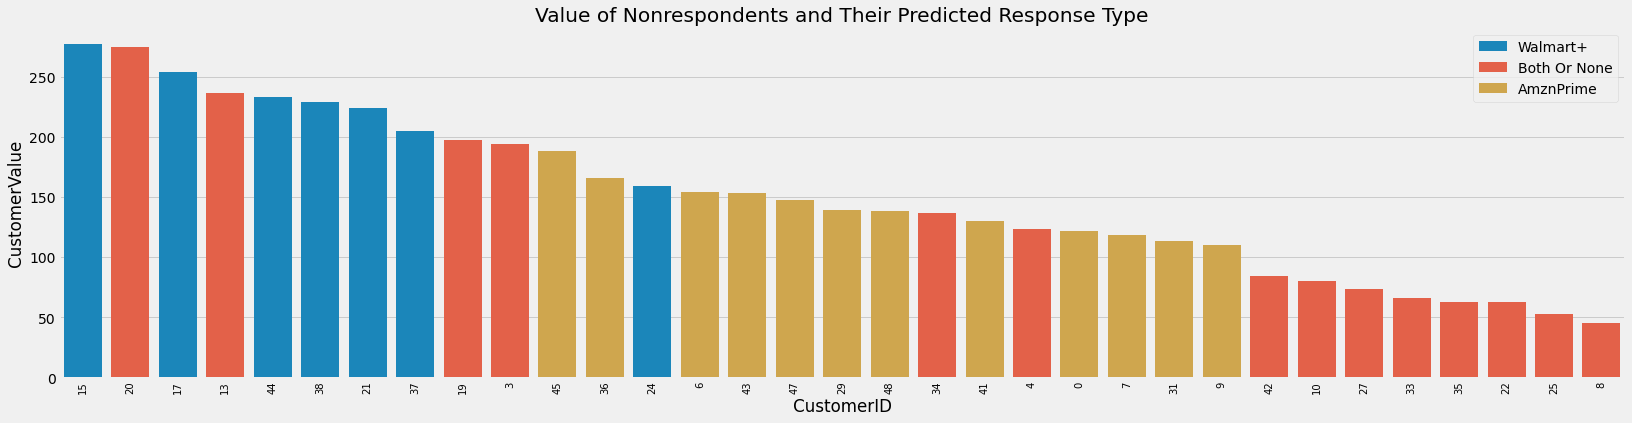

In [89]:
#calculating and visualizing customer value
non_resp['CustomerValue'] = non_resp['OrderCount'] * non_resp['AvgOrderValue']

non_resp_value = non_resp[
                          (non_resp.OrderCount>=10)
                          ].sort_values(by='CustomerValue',ascending=False)

fig, ax = plt.subplots(figsize=(25,6))

sns.barplot(x=non_resp_value.index, y="CustomerValue", data=non_resp_value, 
            order=non_resp_value.index, hue='Pred_Response', dodge=False)

plt.xticks(fontsize=10, rotation=90)
plt.xlabel('CustomerID')
plt.legend(loc='upper right')
plt.title('Value of Nonrespondents and Their Predicted Response Type')

It seems as though a majority of nonrespondents didn't make many purchases. There are some high value nonrespondents, however, that our model predicted as `Both Or None`, and thus present themselves as potential value customers for Walmart. As we have discovered, the lower value, already opinionated `AmznPrime` repondents can be ignored, so Walmart shouldn't pay much attention to those of which our model has predicted.

# K-nearest neighbors (KNN) classification

In [84]:
#instantiating and looping through values of k
k_range = list(range(1, 20))
scores = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

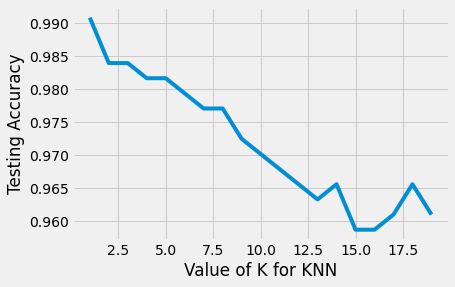

In [85]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

You could also run more out-of-sample testing with this model, but seeing as though the logistic regression performed really well, and for the sake of this case study's length, there is no need. It would also be smart to do some k-fold cv with these k values to truly see which k value is optimal, since lower k values can result in more complex and overfit models.

# Findings:

<br/>

[<img align="left" alt="prime" width="200px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2F2%2F27%2FAmazon_Prime_logo.png&f=1&nofb=1" />][prime] : Customers who prefer Amazon Prime didn't utilize their Walmart+ perks during the pilot program. Both their order amount and order sizes were smaller than those who prefer Walmart, which suggests they could be of lower value to Walmart. Amazon Prime respondents are -EV for Walmart to "recruit". This is because they ordered noticeably less frequently during the pilot program and make up the smallest response group by quite a bit. It also doesn't help that they are already opinionated.

<br/>


[<img align="left" alt="walmart" width="200px" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.gannett-cdn.com%2Fpresto%2F2020%2F09%2F11%2FUSAT%2F71a109b9-ba89-4bbb-9f4e-a55c87a79ae8-4._Asset_Toolkit_Logo_PNG_Walmart_Blue_RGB-01.png&f=1&nofb=1" />][walmart] : Customers who prefer Walmart+ took full advantage of the pilot program, ordering most frequently of all response types. They also logged the largest orders and thus make up some of the most valuable customers in this pilot program. Needless to say, they have the audience they want, and their next step is to recruit the indifferent respondents as they have high ceilings in terms of profit potential.

<br/>


The indifferent respondents is where Walmart could perhaps make some money. Not only did they make up the largest reponse group by a generous amount, but they also make up some of the most valuable customers and ordered frequently during the pilot program. The ceiling of these customers is thus significantly higher than the lesser, lower ceilinged, and already opinionated `AmznPrime` response group.


[walmart]: https://www.walmart.com/plus
[prime]: https://www.amazon.com/amazonprime?_encoding=UTF8&hvadid=78409042974208&hvbmt=be&hvdev=c&hvqmt=e&ref=pd_sl_34qfrygf2j_e&tag=mh0b-20

---

## What I would do with more time:

The end of the semester is incredibly busy right now, but if I had more time with this case study I would like to do numerous things. Building a dashboard that can take out-of-sample data and make a `Response` prediction would be awesome. I would definitely use [Streamlit](https://www.streamlit.io/)  for this (basically Shiny but in python). It is easy for analysts to understand the out of sample testing code provided above, but this isn't suitable for a presentaiton if I were to show it to people who don't know how to code. This is actually one of the main uses for Streamlit apps, and I've seen many that simplify machine learning predictions for presentation purposes (I have applied for streamlit sharing, which is their beta test for free app hosting on their site!). Also, I would like to pursue model evaluation by running K-fold cross validation to pick an optimal k value for the KNN model to avoid overfitting (this can happen with low values of K, as aforementioned). Lastly, it would be interesting to research how false positives/negatives work within multinomial classifcation, and with that, sensitivity and specificity.

## Max Bolger, 2020